#### Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?


наилучшее значение у меня получилось у RFE 
* F1 для RFE: 0.35125035929864906
* F1 для PI: 0.34176722460101205

#### Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

две другие модели у меня catboost + lightgbm
у XGBoost F1 везде выше 

#### Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

F1 по матрице корреляций: 0.33507853403141363

#### Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте.

IV нельзя использовать в качестве метода отбора признаков для модели случайного леса, поскольку она предназначена только для модели логистической регрессии.

In [1]:
# !pip install imblearn
# !pip install eli5

In [2]:
import time
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix
from collections import Counter

import xgboost as xgb, lightgbm as lgbm, catboost as catb
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [3]:
def time_format(sec):
    return str(timedelta(seconds=sec))

In [4]:
def build_dataset_raw(churned_start_date='2019-01-01', 
                      churned_end_date='2019-02-01', 
                      inter_list=[(1,7),(8,14)],
                      raw_data_path='train/',
                      dataset_path='dataset/', 
                      mode='train'):
    
    start_t = time.time()
 
    sample = pd.read_csv('{}sample.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    profiles = pd.read_csv('{}profiles.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    payments = pd.read_csv('{}payments.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    reports = pd.read_csv('{}reports.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    abusers = pd.read_csv('{}abusers.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    logins = pd.read_csv('{}logins.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    pings = pd.read_csv('{}pings.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    sessions = pd.read_csv('{}sessions.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    shop = pd.read_csv('{}shop.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    
    print('Run time (reading csv files): {}'.format(time_format(time.time()-start_t)))    
#-----------------------------------------------------------------------------------------------------    
    print('NO dealing with outliers, missing values and categorical features...')
#-----------------------------------------------------------------------------------------------------        
    # На основании дня отвала (last_login_dt) строим признаки, которые описывают активность игрока перед уходом
    
    print('Creating dataset...')
    # Создадим пустой датасет - в зависимости от режима построения датасета - train или test
    if mode == 'train':
        dataset = sample.copy()[['user_id', 'is_churned', 'level', 'donate_total']]
    elif mode == 'test':
        dataset = sample.copy()[['user_id', 'level', 'donate_total']]

    # Пройдемся по всем источникам, содержащим "динамичекие" данные
    for df in [payments, reports, abusers, logins, pings, sessions, shop]:

        # Получим 'day_num_before_churn' для каждого из значений в источнике для определения недели
        data = pd.merge(sample[['user_id', 'login_last_dt']], df, on='user_id')
        data['day_num_before_churn'] = 1 + (data['login_last_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - 
                                data['log_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(lambda x: x.days)
        df_features = data[['user_id']].drop_duplicates().reset_index(drop=True)

        # Для каждого признака создадим признаки для каждого из времененно интервала (в нашем примере 4 интервала по 7 дней)
        features = list(set(data.columns) - set(['user_id', 'login_last_dt', 'log_dt', 'day_num_before_churn']))
        print('Processing with features:', features)
        for feature in features:
            for i, inter in enumerate(inter_list):
                inter_df = data.loc[data['day_num_before_churn'].between(inter[0], inter[1], inclusive=True)].\
                                groupby('user_id')[feature].mean().reset_index().\
                                rename(index=str, columns={feature: feature+'_{}'.format(i+1)})
                df_features = pd.merge(df_features, inter_df, how='left', on='user_id')

        # Добавляем построенные признаки в датасет
        dataset = pd.merge(dataset, df_features, how='left', on='user_id')
        
        print('Run time (calculating features): {}'.format(time_format(time.time()-start_t)))

    # Добавляем "статические" признаки
    dataset = pd.merge(dataset, profiles, on='user_id')
#---------------------------------------------------------------------------------------------------------------------------
    dataset.to_csv('{}dataset_raw_{}.csv'.format(dataset_path, mode), sep=';', index=False)
    print('Dataset is successfully built and saved to {}, run time "build_dataset_raw": {}'.\
          format(dataset_path, time_format(time.time()-start_t)))

In [5]:
# Следует из исходных данных
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'

INTER_1 = (1,7)
INTER_2 = (8,14)
INTER_3 = (15,21)
INTER_4 = (22,28)
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

In [8]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='train/',
                  dataset_path='dataset/', 
                  mode='train')

Run time (reading csv files): 0:02:39.648574
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['pay_amt', 'trans_amt']
Run time (calculating features): 0:04:29.790955
Processing with features: ['reports_amt']
Run time (calculating features): 0:06:35.989257
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:12:51.525441
Processing with features: ['disconnect_amt', 'session_amt']
Run time (calculating features): 0:20:17.240914
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:27:41.331317
Processing with features: ['kd', 'session_player', 'leavings_rate', 'win_rate']
Run time (calculating features): 0:35:12.636768
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 0:43:01.247966
Dataset is successfully built and saved to d:\GB course\cl-ser\train\dataset\, run time "build_dataset_raw": 0:43:32.587182


In [9]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='test/',
                  dataset_path='dataset/', 
                  mode='test')

Run time (reading csv files): 0:00:07.610781
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['pay_amt', 'trans_amt']
Run time (calculating features): 0:00:10.662880
Processing with features: ['reports_amt']
Run time (calculating features): 0:00:22.610120
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:00:58.640558
Processing with features: ['disconnect_amt', 'session_amt']
Run time (calculating features): 0:01:40.017659
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:02:21.916863
Processing with features: ['kd', 'session_player', 'leavings_rate', 'win_rate']
Run time (calculating features): 0:03:03.515524
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 0:03:47.469282
Dataset is successfully built and saved to d:\GB course\cl-ser\test\dataset\, run time "build_dataset_raw": 0:03:50.276399


In [6]:
def prepare_dataset(dataset, 
                    dataset_type='train',
                    dataset_path='dataset/'):
    print(dataset_type)
    start_t = time.time()
    print('Dealing with missing values, outliers, categorical features...')
    
    # Профили
    dataset['age'] = dataset['age'].fillna(dataset['age'].median())
    dataset['gender'] = dataset['gender'].fillna(dataset['gender'].mode()[0])
    dataset.loc[~dataset['gender'].isin(['M', 'F']), 'gender'] = dataset['gender'].mode()[0]
    dataset['gender'] = dataset['gender'].map({'M': 1, 'F':0})
    dataset['gender'] = dataset['gender'].astype(int)
    
    dataset.loc[(dataset['age'] > 80) | (dataset['age'] < 7), 'age'] = round(dataset['age'].median())
    dataset.loc[dataset['days_between_fl_df'] < -1, 'days_between_fl_df'] = -1
    # Пинги
    for period in range(1,len(INTER_LIST)+1):
        col = 'avg_min_ping_{}'.format(period)
        dataset.loc[(dataset[col] < 0) | 
                    (dataset[col].isnull()), col] = dataset.loc[dataset[col] >= 0][col].median()
    # Сессии и прочее
    dataset.fillna(0, inplace=True)
    dataset.to_csv('{}dataset_{}.csv'.format(dataset_path, dataset_type), sep=';', index=False)
         
    print('Dataset is successfully prepared and saved to {}, run time (dealing with bad values): {}'.\
          format(dataset_path, time_format(time.time()-start_t))) 

In [7]:
train = pd.read_csv('dataset/dataset_raw_train.csv', sep=';')
test = pd.read_csv('dataset/dataset_raw_test.csv', sep=';')

In [8]:
prepare_dataset(dataset=train, dataset_type='train')
prepare_dataset(dataset=test, dataset_type='test')

train
Dealing with missing values, outliers, categorical features...
Dataset is successfully prepared and saved to dataset/, run time (dealing with bad values): 0:00:32.387314
test
Dealing with missing values, outliers, categorical features...
Dataset is successfully prepared and saved to dataset/, run time (dealing with bad values): 0:00:03.150030


In [9]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов

smote_on_1 = int(X_train.shape[0]*3/10) 
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy={1: smote_on_1}). \
                                        fit_sample(X_train, y_train) 

print('До:', Counter(y_train.values))
print('После:', Counter(y_train_balanced))

До: Counter({0: 318955, 1: 9677})
После: Counter({0: 318955, 1: 98589})
Wall time: 11.7 s


In [11]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

# lightgbm
def lightgbm_fit_predict(X_train, y_train, X_test, y_test):
    clf = lgbm.LGBMClassifier(random_state=21)
    clf.fit(X_train, y_train) # eval_metric='aucpr', verbose=10
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [12]:
def catboost_fit_predict(X_train, y_train, X_test, y_test):
    model_catb = catb.CatBoostClassifier(
                                         l2_leaf_reg=5, 
                                         n_estimators=500, 
                                         max_depth=5, 
                                         silent=True, 
                                         random_state=21)
    model_catb.fit(X_train, y_train)
    predict_proba_test = model_catb.predict_proba(X_test)
    predict_test = model_catb.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return model_catb

In [13]:
%%time
fitted_clf_1 = catboost_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.37246192893401014
Recall: 0.28302796528447444
F1: 0.32164383561643833
Log Loss: 0.1000657663164785
ROC AUC: 0.9037041371659089
Wall time: 1min 13s


In [14]:
%%time
fitted_clf_2 = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.28534991232265267
Recall: 0.431533269045323
F1: 0.3435370885711544
Log Loss: 0.1351069925001879
ROC AUC: 0.8999795647653027
Wall time: 30.5 s


In [15]:
%%time
fitted_clf_3 = lightgbm_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.3786587625046313
Recall: 0.2463837994214079
F1: 0.2985249014166788
Log Loss: 0.09653885291434566
ROC AUC: 0.909295898671147
Wall time: 12.5 s


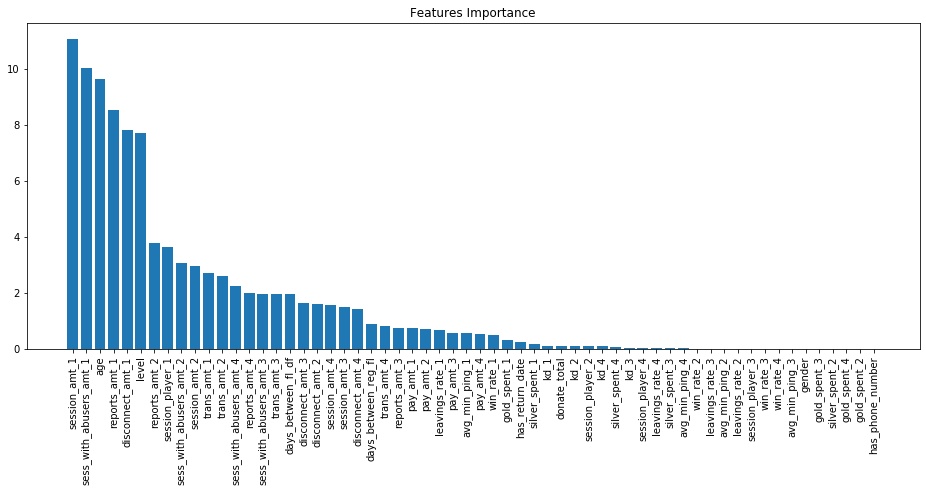

In [16]:
feature_importance = plot_importance(fitted_clf_1.feature_importances_, X.columns, 'Features Importance')

In [17]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_1 = catboost_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.380321665089877
Recall: 0.2907425265188042
F1: 0.3295532176526848
Log Loss: 0.09868229466855975
ROC AUC: 0.904928456749488
Признаков было: 60
Признаков стало: 30


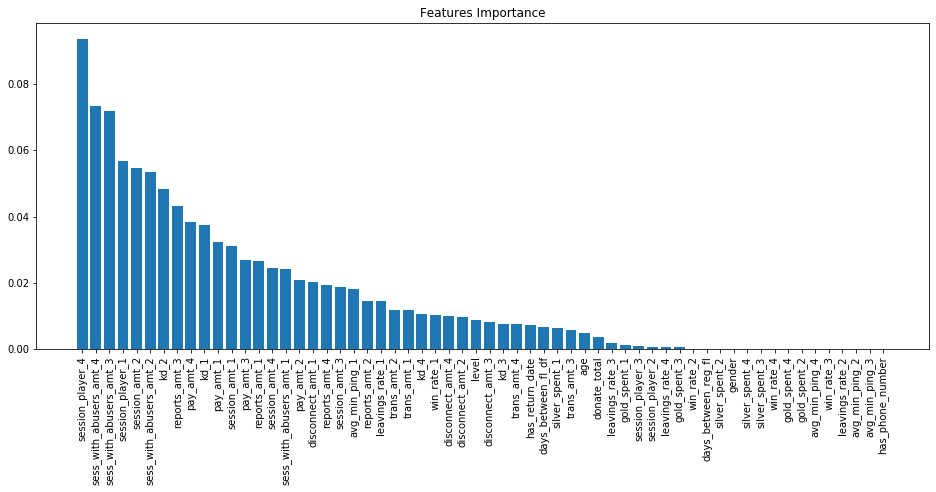

In [18]:
feature_importance = plot_importance(fitted_clf_2.feature_importances_, X.columns, 'Features Importance')

In [19]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_2 = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.2966375687035241
Recall: 0.4423818707810993
F1: 0.3551383781691504
Log Loss: 0.13249478330603295
ROC AUC: 0.8980108246956681
Признаков было: 60
Признаков стало: 30


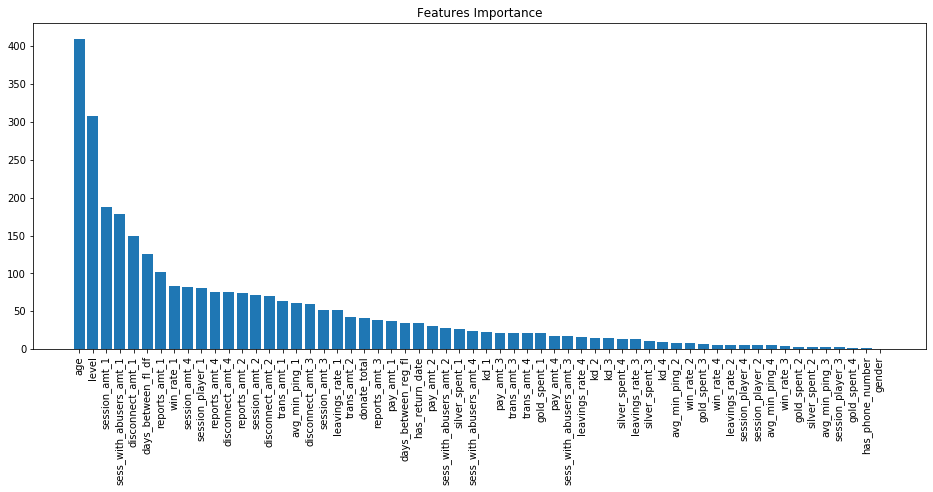

In [20]:
feature_importance = plot_importance(fitted_clf_3.feature_importances_, X.columns, 'Features Importance')

In [21]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_3 = lightgbm_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)


print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3862559241706161
Recall: 0.23577627772420442
F1: 0.29281437125748505
Log Loss: 0.09611928100051925
ROC AUC: 0.9089684402164714
Признаков было: 60
Признаков стало: 30


In [22]:
dataset.corr()

,is_churned,level,donate_total,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,trans_amt_1,trans_amt_2,trans_amt_3,...,silver_spent_1,silver_spent_2,silver_spent_3,silver_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
is_churned,1.000000,-0.082844,-0.035794,-0.023462,-0.027008,-0.025544,-0.026647,-0.033898,-0.038776,-0.037413,...,-0.004901,-0.025124,-0.027034,-0.030019,-0.000006,0.000702,0.002773,0.003479,0.047001,-0.004094
level,-0.082844,1.000000,0.454841,0.122475,0.115875,0.112549,0.108327,0.140020,0.126069,0.121346,...,0.096180,0.095715,0.063428,0.061880,0.184219,-0.026130,-0.021330,-0.091785,-0.148710,0.035303
donate_total,-0.035794,0.454841,1.000000,0.276880,0.291470,0.299948,0.304079,0.217942,0.224616,0.230919,...,0.031764,0.028763,0.015628,0.011489,0.117322,0.006506,-0.018432,-0.136518,-0.068462,0.042521
pay_amt_1,-0.023462,0.122475,0.276880,1.000000,0.289481,0.273826,0.248053,0.664257,0.229194,0.225193,...,0.089681,0.075776,0.062497,0.060288,0.015074,0.008293,0.000276,-0.036781,-0.062699,0.013244
pay_amt_2,-0.027008,0.115875,0.291470,0.289481,1.000000,0.284146,0.275623,0.232319,0.666939,0.229010,...,0.062309,0.089886,0.065552,0.061155,0.015216,0.008396,0.002962,-0.034098,-0.058222,0.014475
pay_amt_3,-0.025544,0.112549,0.299948,0.273826,0.284146,1.000000,0.299678,0.214009,0.220536,0.656702,...,0.062538,0.065730,0.091868,0.058439,0.015797,0.008374,-0.000055,-0.031855,-0.056761,0.016272
pay_amt_4,-0.026647,0.108327,0.304079,0.248053,0.275623,0.299678,1.000000,0.199609,0.221315,0.224511,...,0.056543,0.067944,0.066580,0.085901,0.013809,0.007893,0.002025,-0.032632,-0.055535,0.015361
trans_amt_1,-0.033898,0.140020,0.217942,0.664257,0.232319,0.214009,0.199609,1.000000,0.318803,0.301384,...,0.126604,0.121244,0.096357,0.093020,-0.000101,0.007905,0.002171,-0.037247,-0.089584,0.015843
trans_amt_2,-0.038776,0.126069,0.224616,0.229194,0.666939,0.220536,0.221315,0.318803,1.000000,0.318245,...,0.090956,0.132232,0.098039,0.091320,0.000150,0.009456,0.003616,-0.035740,-0.080589,0.015069
trans_amt_3,-0.037413,0.121346,0.230919,0.225193,0.229010,0.656702,0.224511,0.301384,0.318245,1.000000,...,0.085640,0.099098,0.135529,0.094091,0.000046,0.008478,0.000900,-0.035375,-0.077167,0.018388


In [23]:
def get_corr(data,col):
    return np.abs(data.corr()[col]).sort_values()

feature_importance = get_corr(dataset, 'is_churned').index[30:60]

In [24]:
feature_importance

Index(['silver_spent_2', 'pay_amt_3', 'win_rate_3', 'pay_amt_4', 'pay_amt_2',
       'silver_spent_3', 'silver_spent_4', 'trans_amt_1', 'donate_total',
       'trans_amt_3', 'reports_amt_1', 'win_rate_4', 'trans_amt_2',
       'session_player_1', 'trans_amt_4', 'sess_with_abusers_amt_1',
       'has_return_date', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
       'sess_with_abusers_amt_2', 'session_player_2', 'session_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
       'session_player_3', 'level', 'session_player_4', 'session_amt_3',
       'session_amt_4'],
      dtype='object')

In [25]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance]

fitted_clf_1 = catboost_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3366208149493901
Recall: 0.3126808100289296
F1: 0.3242094738157731
Log Loss: 0.12119265500081576
ROC AUC: 0.8194822697046755
Признаков было: 60
Признаков стало: 30


In [26]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance]

fitted_clf_2 = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.2802465131365553
Recall: 0.4165863066538091
F1: 0.33507853403141363
Log Loss: 0.15034390479627974
ROC AUC: 0.824089226439155
Признаков было: 60
Признаков стало: 30


In [27]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance]

fitted_clf_3 = lightgbm_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)


print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.34869481147276826
Recall: 0.2608486017357763
F1: 0.2984415942628603
Log Loss: 0.11634843802589499
ROC AUC: 0.8174612510949085
Признаков было: 60
Признаков стало: 30


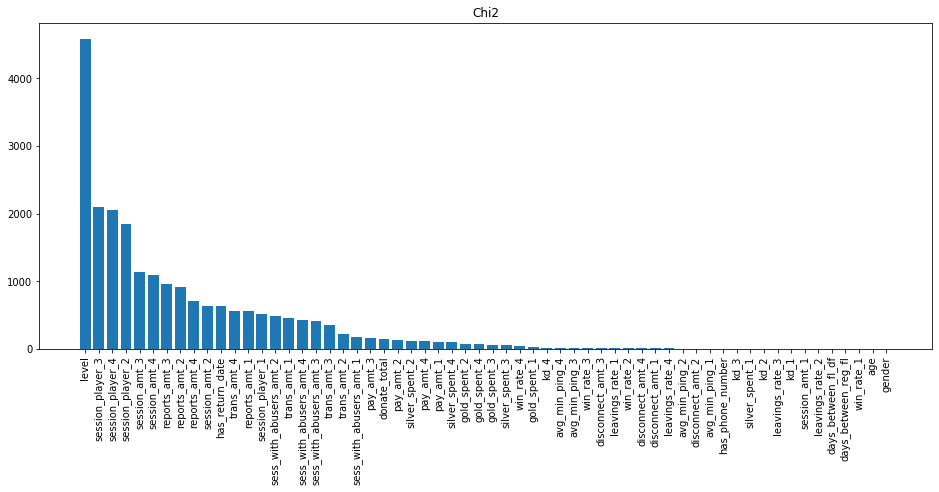

Wall time: 1.12 s


In [28]:
%%time
# Обратите внимание, что значения в датасете должны быть неотрицательными для расчета Хи квартат
chi2_test = chi2(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(chi2_test[0], X.columns, 'Chi2')

In [29]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_CHI = xgb_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.2785668173014848
Recall: 0.41610414657666345
F1: 0.33372003093580815
Log Loss: 0.14985872829240254
ROC AUC: 0.8249015018865776


In [30]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_CHI_1 = catboost_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)


Precision: 0.3377273925652518
Recall: 0.3088235294117647
F1: 0.3226293917642615
Log Loss: 0.12117670186309472
ROC AUC: 0.8182019176846101


In [31]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_CHI_3 = lightgbm_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.350253807106599
Recall: 0.266152362584378
F1: 0.30246575342465754
Log Loss: 0.11630404498820297
ROC AUC: 0.8183955824055997


In [32]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

Wall time: 8min 3s


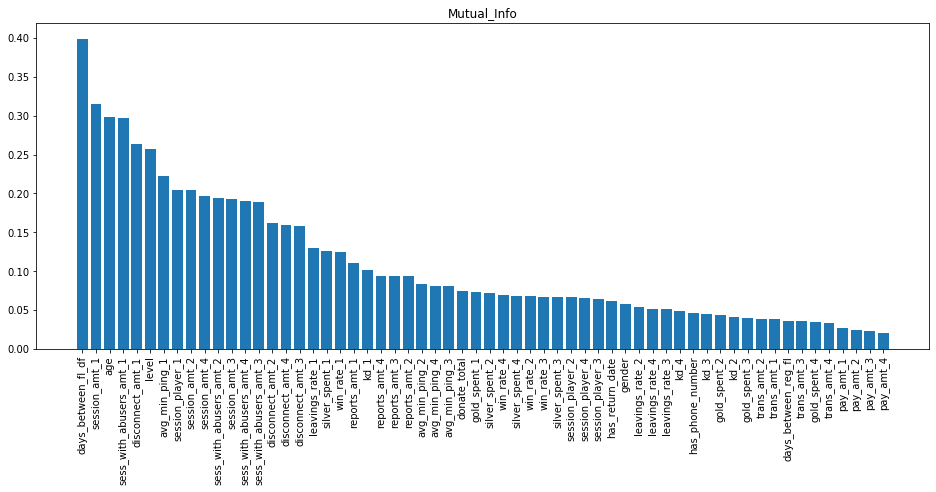

In [33]:
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [34]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_MI = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.28863324175824173
Recall: 0.40525554484088716
F1: 0.33714400320898513
Log Loss: 0.13481063518757816
ROC AUC: 0.8938685927461778
Признаков было: 60
Признаков стало: 30


In [35]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_MI = catboost_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3705386112913692
Recall: 0.27531340405014465
F1: 0.31590594744121714
Log Loss: 0.10208620772892182
ROC AUC: 0.8992912428520329
Признаков было: 60
Признаков стало: 30


In [36]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_MI = lightgbm_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3775633293124246
Recall: 0.226374156219865
F1: 0.2830444611906556
Log Loss: 0.09767696941709351
ROC AUC: 0.9036426841983238
Признаков было: 60
Признаков стало: 30


In [37]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50
Wall time: 1min 40s


In [38]:
good_features

Index(['level', 'donate_total', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3',
       'pay_amt_4', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4',
       'reports_amt_1', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
       'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
       'disconnect_amt_1', 'disconnect_amt_2', 'disconnect_amt_4',
       'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4',
       'avg_min_ping_1', 'avg_min_ping_3', 'avg_min_ping_4', 'kd_1', 'kd_4',
       'session_player_1', 'session_player_2', 'session_player_3',
       'leavings_rate_1', 'leavings_rate_3', 'leavings_rate_4', 'win_rate_1',
       'win_rate_2', 'win_rate_3', 'win_rate_4', 'gold_spent_1',
       'gold_spent_2', 'gold_spent_3', 'gold_spent_4', 'silver_spent_1',
       'silver_spent_2', 'silver_spent_3', 'age', 'days_between_fl_df',
       'has_return_date'],
      dtype='object')

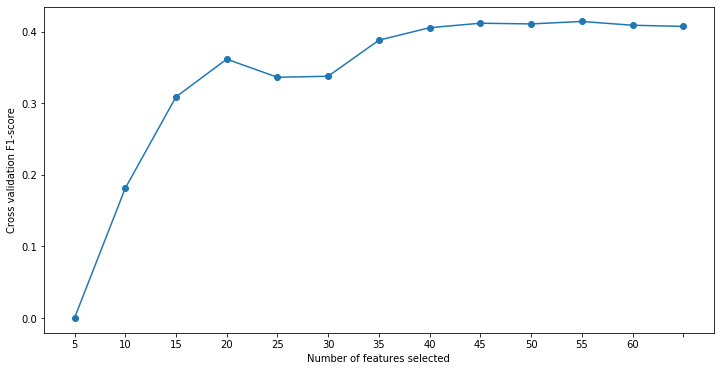

In [39]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [40]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_RFE = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.29146128160279855
Recall: 0.44189971070395373
F1: 0.35125035929864906
Log Loss: 0.13350443194881184
ROC AUC: 0.8996785740576468
Признаков было: 60
Признаков стало: 30


In [41]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_RFE = catboost_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3703233988585923
Recall: 0.2815814850530376
F1: 0.3199123527800602
Log Loss: 0.10017661973344387
ROC AUC: 0.9038726771476653
Признаков было: 60
Признаков стало: 30


In [42]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_RFE = lightgbm_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3851907255048616
Recall: 0.24831243972999037
F1: 0.30196423336265027
Log Loss: 0.09629144278537627
ROC AUC: 0.9096394485283756
Признаков было: 60
Признаков стало: 30


In [43]:
!pip install eli5

In [44]:
# Модуль можно установить, сделав
# !pip install eli5
# А можно использовать локальный модуль
import eli5
from eli5.sklearn import PermutationImportance

In [45]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.28534991232265267
Recall: 0.431533269045323
F1: 0.3435370885711544
Log Loss: 0.1351069925001879
ROC AUC: 0.8999795647653027


In [46]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

Wall time: 4min 38s


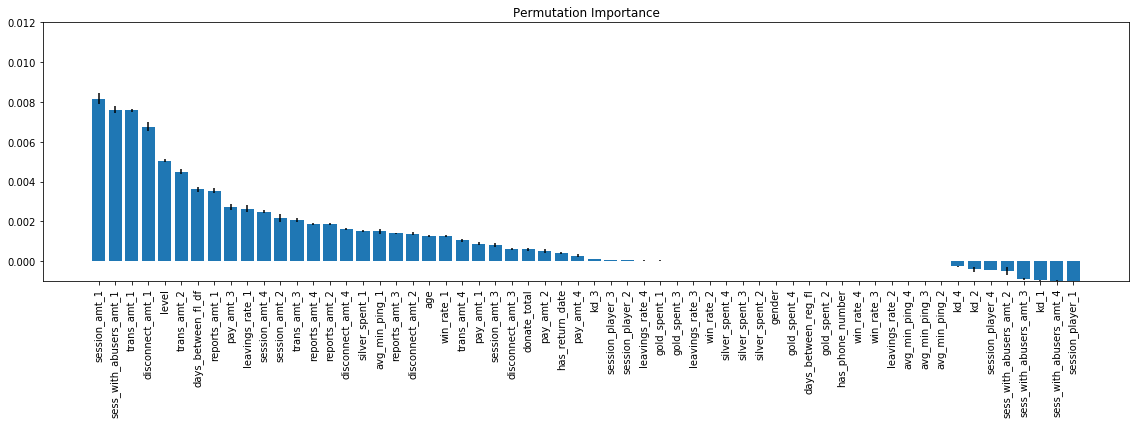

In [47]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [48]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 38


In [49]:
X_train_eli = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_eli = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_eli = xgb_fit_predict(X_train_eli, y_train_balanced, X_test_eli, y_test)

Precision: 0.28655352480417756
Recall: 0.42333654773384766
F1: 0.34176722460101205
Log Loss: 0.13652326738636575
ROC AUC: 0.8961242435462348


In [50]:
X_train_eli = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_eli = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_eli = catboost_fit_predict(X_train_eli, y_train_balanced, X_test_eli, y_test)

Precision: 0.37095253065073874
Recall: 0.2844744455159113
F1: 0.32200845954427615
Log Loss: 0.1008359640417735
ROC AUC: 0.9013486778718841


In [51]:
X_train_eli = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_eli = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_eli = lightgbm_fit_predict(X_train_eli, y_train_balanced, X_test_eli, y_test)

Precision: 0.3773946360153257
Recall: 0.23746383799421408
F1: 0.2915063628292394
Log Loss: 0.09658205733218196
ROC AUC: 0.9095174032469149
